#Paquetes necesarios

Tarea 1: Comprobamos que tenemos el entorno preparado para usar CUDA

In [1]:
import torch
print(torch.cuda.is_available())

False


In [ ]:
from ultralytics import YOLO
import torch

ruta = "../P4_opcion3/Dataset/data.yaml"

# Verifica si CUDA está disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Carga el modelo en el dispositivo especificado
model = YOLO('yolo11n.pt').to(device)

# Configura y ejecuta el entrenamiento
results = model.train(data=ruta, epochs=40, imgsz=640, device=device)

Ultralytics 8.3.25 🚀 Python-3.9.18 torch-2.2.2 CPU (Intel Core(TM) i5-7360U 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=../P4_opcion3/YOLODataset/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

RuntimeError: Dataset '../P4_opcion3/YOLODataset/data.yaml' error ❌ '../P4_opcion3/YOLODataset/data.yaml' does not exist

Imprimimos información de la GPU


0: 576x640 1 car, 3 stop signs, 1106.5ms
Speed: 68.9ms preprocess, 1106.5ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 pl_license_plate, 221.9ms
Speed: 5.3ms preprocess, 221.9ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Matrícula Detectada: 9556 KTR


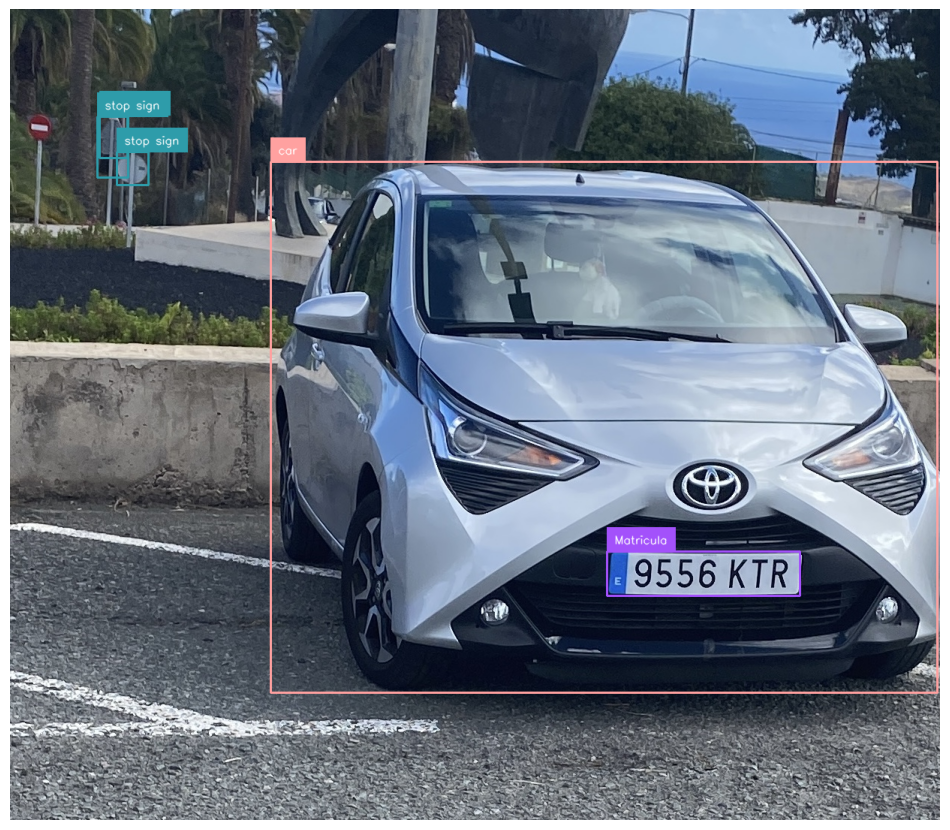

In [2]:
import cv2  
from ultralytics import YOLO
import easyocr
import supervision as sv
from supervision.draw.color import ColorPalette
import numpy as np
import torch

# Se carga el modelo de Yolo11
model_person_and_car = YOLO('yolo11n.pt').to('cpu')

# Se lee la imagen que vamos a utilizar de prueba.
image = cv2.imread("katrina3.jpg")

# Funcion utilizada para devolver la imagen de la caja delimitadora del objeto detectado 
def cropped(detections, image):
    bounding_box = detections.xyxy
    xmin, ymin, xmax, ymax = bounding_box[0]
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    return image[ymin:ymax, xmin:xmax]


# Recogeremos el primer resultado del modelo de personas y coches de Yolo11
result = model_person_and_car(image)[0]

# Nos permite manejar las detecciones de forma mas sencilla
detections_t = sv.Detections.from_ultralytics(result)

# Clase de interes 2 porque, 2 = Car
class_id_of_interest = [2]

mask = [class_id in class_id_of_interest for class_id in detections_t.class_id]
if any(mask):

    # Inicializamos las etiquetas
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Se pasa la informacion que se mostrara en las etiquetas
    annotated_image_t = bounding_box_annotator.annotate(scene=image, detections=detections_t)
    annotated_image_t = label_annotator.annotate(scene=annotated_image_t, detections=detections_t)

    # Aplicamos la funcion comentada anteriormente para tener una imagen mas directa de car detectado
    cropped_image_t = cropped(detections_t, image)

    # Aplicamos ahora el modelo especializado en matriculas de coches.
    model_p = YOLO('yoloMatric.pt').to('cpu')

    # Modificamos el nombre que trae por defecto el modelo a "Matricula"
    results_p = model_p(cropped_image_t, agnostic_nms=True)[0]
    results_p.names[0] = "Matricula"

    detections_p = sv.Detections.from_ultralytics(results_p)

    # Aplicamos la funcion comentada anteriormente para tener una imagen mas directa de la matricula
    cropped_image_matricula = cropped(detections_p, cropped_image_t)

    # Extraemos las coordenadas de la matricula y realizamos una diferencia para pasarlas a la imagen original
    dif_x = results_p.boxes.xyxy[0][2] - results_p.boxes.xyxy[0][0]
    dif_y = results_p.boxes.xyxy[0][3] - results_p.boxes.xyxy[0][1]

    # Puntos iniciales, suma del punto de deteccion de la matricula mas el del coche
    x1_nuevo = detections_t.xyxy[0][0] + detections_p.xyxy[0][0]
    y1_nuevo = detections_t.xyxy[0][1] + detections_p.xyxy[0][1]

    # Puntos finales, suma del punto inicial mas las dimensiones de la box de matricula
    x2_nuevo = x1_nuevo + dif_x  
    y2_nuevo = y1_nuevo + dif_y 

    # Guardamos las coordenadas
    detections_p.xyxy = np.array([[x1_nuevo, y1_nuevo, x2_nuevo, y2_nuevo]])

    # Inicializamos las etiquetas de la matricula
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Se pasa la informacion que se mostrara en las etiquetas
    annotated_image_p = bounding_box_annotator.annotate(scene=image, detections=detections_p)
    annotated_image_p = label_annotator.annotate(scene=annotated_image_p, detections=detections_p)

    # Inicializamos el lector de EasyOCR y procesamos la imagen de la matrícula
    reader = easyocr.Reader(['en'])
    gray = cv2.cvtColor(cropped_image_matricula, cv2.COLOR_BGR2GRAY)
    result = reader.readtext(gray, detail=0)

    # Limpieza y muestra del texto detectado
    if result:
        data = result[0]
        print("Matrícula Detectada:", data)
        text = "Matricula: " + data
    else:
        text = "No se detectó texto en la imagen de la matrícula"
        print(text)

        
# Mostramos por consola la imagen resultante
sv.plot_image(annotated_image_p)


Entrenamos el modelo

In [3]:
import cv2
import torch
from ultralytics import YOLO
import supervision as sv
import os
import csv
import warnings
import easyocr  # Importamos EasyOCR para reconocer el texto de la matrícula

# Eliminamos los posibles warning que salgan por consola.
warnings.filterwarnings("ignore")

# Configuración de CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando el dispositivo: {device}")

# Cargar modelos y usar el device detectado preferiblemente CUDA
model_person_and_car = YOLO('yolo11n.pt').to(device)
model_p = YOLO('final.pt').to(device)

# Inicializamos el lector de OCR
reader = easyocr.Reader(['en'], gpu=device == 'cuda')

# Inicializamos captura de video
cap = cv2.VideoCapture('C0142_corto.mp4')

# Configuración para guardar el video de salida
output_video_path = os.path.join(os.getcwd(), 'output.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS), 
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Archivo CSV para registrar las detecciones
csv_file_path = os.path.join(os.getcwd(), 'detections.csv')
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow([
        'Frame', 'Object_Type', 'Confidence', 'Tracking_ID', 'x1', 'y1', 'x2', 'y2', 
        'License_Plate_Detected', 'Plate_Confidence', 'mx1', 'my1', 'mx2', 'my2', 'Plate_Text'
    ])

# Contadores de detección
total_personas = 0
total_coches = 0
total_matriculas = 0

# Función para recortar la imagen según la detección
def cropped(detections, image):
    if detections.xyxy.shape[0] > 0:
        xmin, ymin, xmax, ymax = map(int, detections.xyxy[0])
        return image[ymin:ymax, xmin:xmax]
    return None


# Contador de frames para en el CSV establecer en que frame se detecto dicha detección
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    # Detección de personas y autos en el frame original
    result = model_person_and_car(frame, verbose=False)[0]
    detections_t = sv.Detections.from_ultralytics(result)
    
    # Por cada detección recogemos la clase, la confianza, el id de seguimiento y sus coordenadas
    for detection in detections_t:
        if detection is None or len(detection) < 5:
            continue

        obj_class = detection[5]['class_name']  # Clase
        confidence = detection[2]  # Confianza
        tracking_id = detection[3]  # ID de seguimiento
        bbox = detection[0]  # Coordenadas
        
        # Definimos el tipo de clase detectada y si es aumentamos en 1 el contador de dicha clase (Persona o Coche)
        if obj_class == 'person':  # Persona
            obj_type = 'Person'
            total_personas += 1
        elif obj_class == 'car':  # Coche
            obj_type = 'Car'
            total_coches += 1
        else:
            continue  # Ignorar otras clases

        # Guardamos la detección en el CSV
        with open(csv_file_path, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([
                frame_number, obj_type, confidence, tracking_id, bbox[0], bbox[1], bbox[2], bbox[3], '', '', '', '', '', ''
            ])

    # Procesar matrículas en las detecciones de coches
    class_id_of_interest = [2]  # Solo coches
    mask = [class_id in class_id_of_interest for class_id in detections_t.class_id]
    
    # Anotar todas las detecciones en el frame
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Anotar todas las detecciones en el frame
    annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections_t)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_t)

    if any(mask):
        # Recortar el área del coche y verificar que el recorte no sea None
        cropped_image_t = cropped(detections_t, frame)
        if cropped_image_t is not None:
            # Una vez tengamos la imagen resultante le aplicamos un resize
            cropped_image_resized = cv2.resize(cropped_image_t, (832, 512))
            results_p = model_p(cropped_image_resized, verbose=False)[0]  # Aplicamos el modelo y tomamos solo el primer resultado
            detections_p = sv.Detections.from_ultralytics(results_p)

            # Nos aseguramos de que las coordenadas de la caja delimitadora sean superiores a 0 de la primera detección
            if detections_p.xyxy.shape[0] > 0:
                for detection in detections_p:
                    total_matriculas += 1  # Aumentamos el contador de matricula
                    plate_bbox = detection[0]  # Coordenadas de la matricula
                    plate_confidence = detection[2]  # Confianza de la matricula
                    px1, py1, px2, py2 = map(int, plate_bbox)  # Dividimos las coordenadas en 4 variables
                    
                    # Aplicar OCR a la región de la matrícula para obtener el texto
                    plate_image = cropped_image_resized[py1:py2, px1:px2]  # Recortar solo la región de la matrícula
                    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
                    result_text = reader.readtext(gray, detail=0)  # Leer texto
                    plate_text = result_text[0] if result_text else ''  # Obtener el texto si es reconocido

                    # Guardar en el CSV
                    with open(csv_file_path, mode='a', newline='') as csv_file:
                        csv_writer = csv.writer(csv_file)
                        csv_writer.writerow([
                            frame_number, 'License Plate', confidence, tracking_id, bbox[0], bbox[1], bbox[2], bbox[3],
                            'Yes', plate_confidence, px1, py1, px2, py2, plate_text
                        ])
                    
                    # Dibujar la caja delimitadora en la imagen original
                    cv2.rectangle(frame, (px1, py1), (px2, py2), (0, 255, 0), 2)  # Dibuja la caja verde
                    # Añadir el texto en la imagen original
                    cv2.putText(frame, plate_text, (px1, py1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Escribir el frame anotado en el video de salida
    out.write(annotated_frame)
    cv2.imshow('Video', annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Resumen en consola
print(f"Coches detectados: {total_coches}")
print(f"Matrículas detectadas: {total_matriculas}")

cap.release()
out.release()
cv2.destroyAllWindows()


Usando el dispositivo: cpu


Using CPU. Note: This module is much faster with a GPU.


Coches detectados: 2555
Matrículas detectadas: 169
